## Задания

1. Написать функцию, переводящую изображение в матрицу столбцов - im2col(). На вход функция принимает изображение и размер свёртки, возвращает столбцы.
2. Написать функцию свёртки, которая работает без циклов. Вместо циклов, она использует im2col(), для перевода изображения в набор столбцов.
3. Сравнить результаты с torch.nn.Conv2d

### Task1-2

In [5]:
import numpy as np

In [6]:
from typing import List, Tuple, Optional
from numpy.typing import NDArray

In [7]:
# https://github.com/jssonx/lightneuron/blob/b6686edc147cf0a0695229f95ed538a4f6175a79/kernel/conv.c#L1

In [8]:
def im2col(image: np.ndarray, kernelSize: int, stride: int) -> np.ndarray:
    numChannels = image.shape[0]
    imageSize = image.shape[1]
    outputRows = kernelSize * kernelSize * numChannels
    outputCols = int(((imageSize - kernelSize) / stride) + 1) ** 2

    output = np.zeros((outputRows, outputCols))

    colIdx = 0
    for row in range(0, imageSize - kernelSize + 1, stride):
        for col in range(0, imageSize - kernelSize + 1, stride):
            for c in range(numChannels):
                for i in range(kernelSize):
                    for j in range(kernelSize):
                        outputRow = c * kernelSize * kernelSize + i * kernelSize + j
                        output[outputRow][colIdx] = image[c][row + i][col + j]
            colIdx += 1
    return output

In [9]:
numChannels = 3
imageSize = 5
kernelSize = 3
stride = 1

image = np.random.randint(0, 256, (numChannels, imageSize, imageSize))

img_col= im2col(image, kernelSize, stride)

In [10]:
img_col.shape

(27, 9)

In [11]:
def col2im (result_conv : np.ndarray, num_filters : int, conv_rows : int, conv_cols : int) -> np.ndarray:

    convolutions = np.zeros((num_filters,conv_rows ,conv_cols))

    for k in range (num_filters):
        for  i in range(conv_rows):
            for j in range(conv_cols):
                convolutions[k][i][j] = result_conv[k][i * conv_cols + j]
    result = np.array(convolutions)
    return result

In [12]:
num_filters = 1
kernel_col = np.random.rand(num_filters, kernelSize * kernelSize * numChannels)


In [13]:
result_col = np.dot(kernel_col, img_col)

In [14]:
result = col2im (result_col, num_filters, imageSize - kernelSize + 1, imageSize - kernelSize + 1)

In [15]:
result.shape

(1, 3, 3)

### Task3

In [16]:
import torch
import torch.nn as nn

In [17]:
conv = nn.Conv2d(in_channels=3, out_channels=1, kernel_size=3, stride=1)

In [18]:
from torchvision import transforms

In [19]:
to_tensor = transforms.ToTensor()
image_tensor = to_tensor(image)

## Лабораторная

0. Принимается только после демонстрации функции im2col() из задания выше.
1. Задача классификации изображений (https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html?highlight=mnist). Повторить тренировку модели (train) и запустить классификацию изображений (inference).
2. Получить максимальную точность классификации (минимальный loss) путём изменения модели, например, добавлением скрытых слоёв.
3. По возможности обучить на GPU.

In [20]:
import torch
import torchvision
import torchvision.transforms as transforms

In [45]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5,), (0.5,))])

batch_size = 64

trainset = torchvision.datasets.MNIST(root='./data', train=True,
                                        download=True, transform=transform)
train_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.MNIST(root='./data', train=False,
                                       download=True, transform=transform)
test_loader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('0', '1', '2', '3',
           '4', '5', '6', '7', '8', '9')

In [22]:

import matplotlib.pyplot as plt
import numpy as np

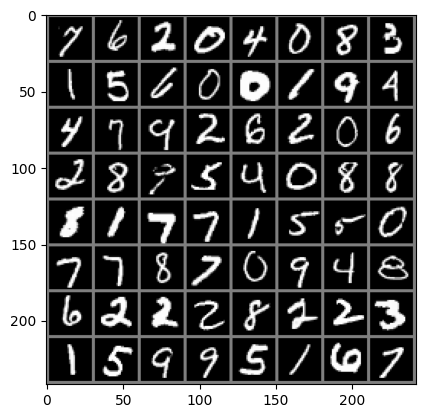

In [46]:
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(train_loader)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images))


In [60]:
import torch.nn as nn
import torch.nn.functional as F


class Model(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(32 * 7 * 7, 128)
        self.fc2 = nn.Linear(128, 10)
        self.pool = nn.MaxPool2d(2, 2)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 32 * 7 * 7)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x


In [61]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = Model().to(device)

In [62]:
lossFunction = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [59]:
num_epochs = 5

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()

        outputs = model(images)
        loss = lossFunction(outputs, labels)

        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()


    average_loss = running_loss / len(train_loader)
    accuracy = 100 * correct / total

    print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {average_loss:.4f}, Accuracy: {accuracy:.2f}%')

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7a6ad8042950>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1604, in __del__
Exception ignored in:     self._shutdown_workers()<function _MultiProcessingDataLoaderIter.__del__ at 0x7a6ad8042950>
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1587, in _shutdown_workers

    if w.is_alive():Traceback (most recent call last):

  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1604, in __del__
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
        self._shutdown_workers()assert self._parent_pid == os.getpid(), 'can only test a child process'
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1587, in _shutdown_workers

AssertionError    : can only test a child process
if w.is_alive():
  File "/usr/lib/

Epoch [1/5], Loss: 0.0078, Accuracy: 99.72%
Epoch [2/5], Loss: 0.0052, Accuracy: 99.83%
Epoch [3/5], Loss: 0.0053, Accuracy: 99.81%
Epoch [4/5], Loss: 0.0055, Accuracy: 99.80%
Epoch [5/5], Loss: 0.0037, Accuracy: 99.88%


In [57]:
def test(model, test_loader) :
    model.eval()
    total = 0
    correct = 0
    with torch.no_grad() :
         for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    test_accuracy = 100 * correct / total
    print(f'Accuracy: {test_accuracy:.4f}')

In [58]:
test(model, test_loader)

Accuracy: 98.9300
